<a href="https://colab.research.google.com/github/nelsonalbertohj/EmotionNet/blob/main/Emotion_recognition_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install biosppy

In [213]:
import json
import pandas as pd
import os
import numpy as np
import scipy.signal as sig
from biosppy.signals.bvp import bvp
from biosppy.signals.eda import eda
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.model_selection import train_test_split
from scipy.signal import butter, lfilter, iirnotch, welch
import scipy.stats as st
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

%matplotlib inline

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

### Data Preparation

![dataset_sampling_rates.png](https://github.com/nelsonalbertohj/EmotionNet/blob/main/Images/dataset_sampling_rates.png?raw=1)

Data is collected from the Emognition file system and pre-processed such that all signals are filtered in the appropriate frequency ranges and sampled at a consitent rate.

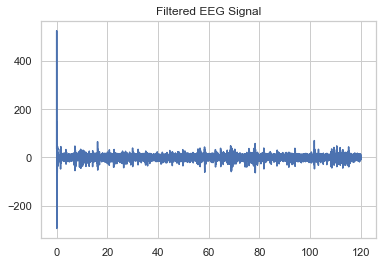

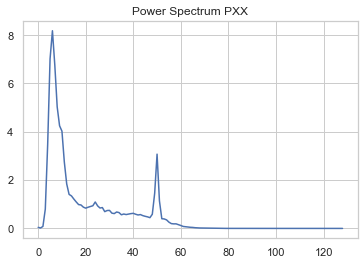

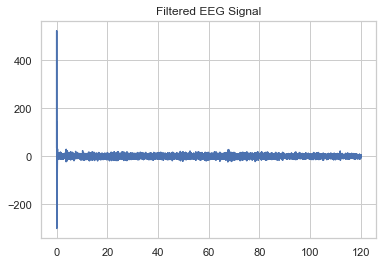

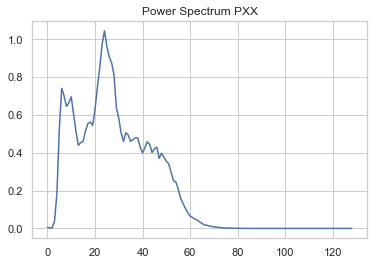

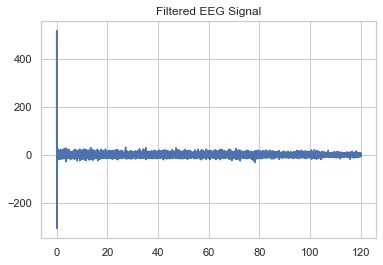

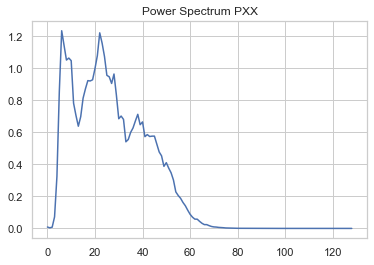

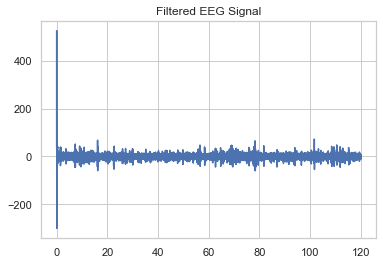

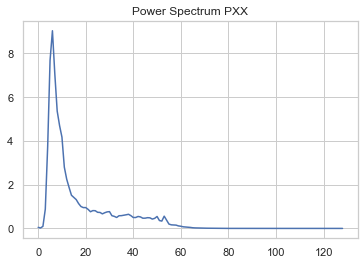

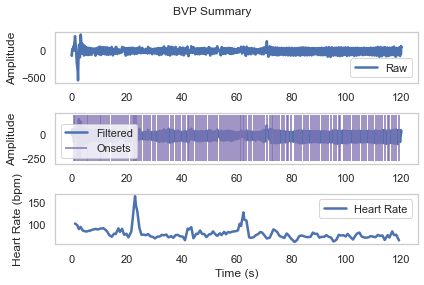

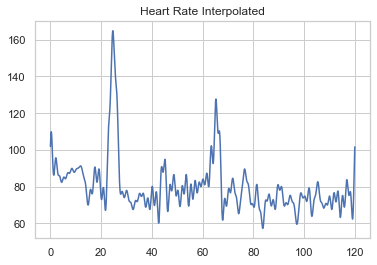

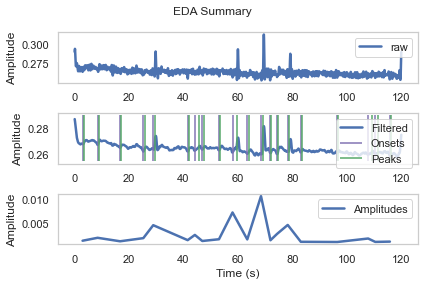

array([0.28718999, 0.28714483, 0.28709843, ..., 0.27497005, 0.2750411 ,
       0.27511047])

In [220]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    '''
    Performs bandpass filter on EEG data

    data: array, of shape channels by samples
    lowcut: int, the lower cut-off frequency
    highcut: int, the higher cut-off frequency
    fs: int, sampling frequency of the signal
    order: int, the order of the butterworth filter

    return: array, of same shape as data with filtered data
    '''
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

def eeg_analysis(eeg_data,l_freq=5,h_freq=55, do_plot = False):
    '''
    Loads data from Muse 2 headset from the .json Emogniton files to a DataFrame with the provided signal, but
    it includes in addition the filtered EEG data and the Power spectral density.

    eeg_data: dict, loaded from json files
    l_freq: int, the lowest frequency to filter from
    h_freq: int, the highest frequency to filter up to
    do_plot: bool, a boolean that will indicate whether the data plots are displayed

    return: tuple, returns a DataFrame with the filtered signals and the length of the signal
    '''

    eeg_df = pd.DataFrame.from_dict(eeg_data)
    eeg_timestamp = eeg_df.pop("TimeStamp")
    eeg_df = eeg_df.astype("float32")
    eeg_df.drop(['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9',
               'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7',
               'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8',
               'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10'],axis=1,inplace=True)

    eeg_df = eeg_df.interpolate() # Use interpolate to fill any Nan values in the data
    eeg_df["TimeStamp"] = eeg_timestamp

    # Iterate through each channel of raw EEG data and filter it
    for eeg_chan in ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']:
        filtered_eeg = butter_bandpass_filter(eeg_df[eeg_chan].to_numpy(), l_freq, h_freq, 256, order=4)
        freq , pxx = sig.welch(filtered_eeg[256:],256)
        pxx_resampled = sig.resample(pxx,len(filtered_eeg))

        if do_plot: # Plot the power spectrum of the EEG data
            plt.figure()
            plt.plot([t/256 for t in range(len(filtered_eeg))],filtered_eeg)
            plt.title("Filtered EEG Signal")

            plt.figure()
            plt.plot(freq,pxx)
            plt.title("Power Spectrum PXX")

        eeg_df["FILT_"+eeg_chan.split("_")[1]] = filtered_eeg
        eeg_df["PXX_"+eeg_chan.split("_")[1]] = pxx_resampled

    eeg_sig_len = len(eeg_df[:])
    return eeg_df[:], eeg_sig_len

def bvp_analysis(data,eeg_len,do_plot = False):
    ''' 
    Analyzes BVP data using biosppy tool and resamples signal to match EEG data length.
    Returns: tuple, filtered BVP data and heart rate estimate
    '''

    bvp_data = np.array(data['BVP'])[:,-1].astype('float32')
    bvp_data = sig.resample(bvp_data,eeg_len)
    _, _, _, _, heart_rate = bvp(bvp_data,256,show=do_plot)
    heart_rate = sig.resample(heart_rate,eeg_len)

    if do_plot:
        plt.figure()
        plt.plot([i/256 for i in range(len(heart_rate))],heart_rate)
        plt.title("Heart Rate Interpolated")
    return bvp_data,heart_rate

def eda_analysis(data,eeg_len,do_plot = False):
    ''' 
    Analyzes EDA data using biosppy tool and resamples signal to match EEG data length.
    Returns: tuple, filtered EDA data
    '''
    
    eda_data = np.array(data['EDA'])[:,-1].astype('float32')

    eda_data = sig.resample(eda_data,eeg_len)
    _, filtered_eda, _, _, _ = eda(eda_data,256,show=do_plot)
    return filtered_eda

# Visualize signals from first participant

with open(r"C:\Users\nelso\Desktop\18065 Project Data\Emognition\22\22_AMUSEMENT_STIMULUS_MUSE.json") as json_file:
    eeg_data = json.load(json_file)
    eeg_df, eeg_sig_len = eeg_analysis(eeg_data,do_plot = True)

with open(r"C:\Users\nelso\Desktop\18065 Project Data\Emognition\22\22_AMUSEMENT_STIMULUS_EMPATICA.json") as json_file:
    data = json.load(json_file)

bvp_analysis(data,eeg_sig_len,True)

eda_analysis(data,eeg_sig_len,True)

In [172]:
file_loc = r"C:\Users\nelso\Desktop\18065 Project Data\Emognition"

In [173]:
# Segment emotion data into a dictionary that is organized as follows:
# per_user_stimulus_arr = {"USER":
#                              {"EMOTION": "pd.DataFrame() with the data corresponding to the emotion"}}

emotions = ["BASELINE","NEUTRAL","AMUSEMENT","ANGER","AWE","DISGUST","ENTHUSIASM","FEAR","LIKING","SADNESS","SURPRISE"]

class DeviceMissing(Exception):
    """ The device that you are looking for is missing from this file directory """
    pass

devices_of_interest = ["MUSE","EMPATICA"] #MUSE must be loaded first!
Testing = False
per_user_labels = {}
per_user_stimulus_arr = {}
for root,dir,_ in os.walk(file_loc):
    for d in dir:
        participant = os.path.join(root,d)

        #Map user to Label in Dicionary
        emotion_dict = {e:{} for e in emotions}
        labels_loc = participant + "\\" + d + "_QUESTIONNAIRES.json"
        with open(labels_loc) as json_file:
            quest_results = json.load(json_file)
            for condition in quest_results['questionnaires']:
                cond_type = condition["movie"]
                emotion_dict[cond_type] = condition["emotions"]
        per_user_labels[d] = emotion_dict
        per_user_stimulus_arr[d] = {}
        
        # Iterate through every emotion and the device of interest to collect the all user data
        for emotion in emotions:
            for device in devices_of_interest:
                data_loc = participant + f"\\{d}_{emotion}_STIMULUS_{device}.json"

                try:
                    with open(data_loc) as json_file:
                        data = json.load(json_file)
                        if device == "MUSE":
                            per_user_stimulus_arr[d][emotion],eeg_sig_len = eeg_analysis(data, do_plot= Testing)
                        elif device == "EMPATICA":
                            bvp_data, heart_rate = bvp_analysis(data,eeg_sig_len,do_plot=Testing)
                            per_user_stimulus_arr[d][emotion]["BVP_Filt"] = bvp_data
                            per_user_stimulus_arr[d][emotion]["HR_EMPATICA"] = heart_rate
                            filt_eda = eda_analysis(data,eeg_sig_len,do_plot = Testing)
                            per_user_stimulus_arr[d][emotion]["EDA_EMPATICA"] = filt_eda
                        else:
                            raise DeviceMissing
                except FileNotFoundError:
                    break
                except Exception as e:
                    raise e

In [178]:
# Extract data into numpy arrays that will later be used for analysis

signals_of_interest = ['FILT_TP9', 'FILT_AF7', 'FILT_AF8', 'FILT_TP10','HR_EMPATICA','EDA_EMPATICA','BVP_Filt']
rated_emotions = emotions[2:] # The emotions that the user rated
target_emotions = emotions[1:] # The emotions that the video intended to evoke

window_len, overlap_len = 30*256, 25*256 # window length of 30 seconds with 25 seconds overlap
slide_len = window_len - overlap_len # length o
target_size = 256*115 # target size for overall length of the video that we will sample from
all_sig_arr = np.zeros([1,target_size,len(signals_of_interest)])
all_labels_arr = np.zeros([1,len(rated_emotions)])

# Keeps track of the mapping from indices to emotion labels
labels_arr_order = {e:i for i,e in enumerate(per_user_labels["22"]["BASELINE"].keys())}
affect_arr_order = {e:i for i,e in enumerate(target_emotions)}
user_to_idx_map = np.zeros([1,1])
emotion_to_idx_map = np.zeros([1,1])

resample_signal = True # Setting that determines whether signal will be downsampled

arr_idx = 0
for user in per_user_stimulus_arr:
    user_data = per_user_stimulus_arr[user]
    for affect in user_data:
        if affect == "BASELINE":
            continue #continue onto the next loop

        #Get array of labels:
        labels = np.zeros([1,len(rated_emotions)])
        user_labels = per_user_labels[user]
        for e in rated_emotions:
            labels[0,labels_arr_order[e]] = user_labels[affect][e]

        all_labels_arr = np.vstack([all_labels_arr,labels])
        user_to_idx_map = np.vstack([user_to_idx_map, user])
        emotion_to_idx_map = np.vstack([emotion_to_idx_map, affect_arr_order[affect]])

        #Get signal arrays (excluding the first and last minute of data:
        data_chunk = user_data[affect][signals_of_interest].to_numpy()[256:target_size+256]
        data_len,num_chan = data_chunk.shape
        while data_len != target_size: #make all data the same by circularly duplicating data
            data_chunk = np.vstack([data_chunk,data_chunk[:target_size-data_len]])
            data_len = data_chunk.shape[0]

        all_sig_arr = np.vstack([all_sig_arr,data_chunk[np.newaxis,:,:]])
        arr_idx += 1


#Epoching arrays:
split_arr = [all_sig_arr[1:,start:start + window_len,:]
             for start in range(0,data_len - window_len,slide_len)]
num_splits = len(split_arr)
new_sig_arr = np.vstack(split_arr) # create new array based on data splits

# Create new_labels_arr with labels that match the new splits of the data
new_labels_arr = np.vstack([all_labels_arr[1:,:] for _ in range(num_splits)])
user_to_idx_arr = np.vstack([user_to_idx_map[1:,:] for _ in range(num_splits)])
emotion_to_idx_arr = np.vstack([emotion_to_idx_map[1:,:] for _ in range(num_splits)])

if resample_signal:
    new_sig_arr = sig.resample(new_sig_arr,num= new_sig_arr.shape[1]//4, axis=1)

KeyboardInterrupt: 

In [19]:
#Save data arrays:
np.save(r"C:\Users\nelso\Desktop\18065 Project Data\emognition_labels_arr.npy",new_labels_arr)
np.save(r"C:\Users\nelso\Desktop\18065 Project Data\emognition_signal_arr.npy",new_sig_arr)
np.save(r"C:\Users\nelso\Desktop\18065 Project Data\emognition_user_to_idx_arr.npy",user_to_idx_arr)
np.save(r"C:\Users\nelso\Desktop\18065 Project Data\emognition_emotion_to_idx_arr.npy",emotion_to_idx_arr.astype("int"))

In [257]:
with open(r"C:\Users\nelso\Desktop\18065 Project Data\emognition_emotion_to_idx_map.json","w") as json_file:
    json.dump(labels_arr_order, json_file)

### Loading Data for Training and Post Analysis

In [8]:
#Load data array
root = r"C:\Users\nelso\Google Drive\School\MIT Spring2022\18.065\18065 Project"
processed_arr = np.load(fr"{root}\Project Data\emognition_signal_arr.npy")
processed_labels = np.load(fr"{root}\Project Data\emognition_labels_arr.npy")
labels_to_user = np.load(fr"{root}\Project Data\emognition_user_to_idx_arr.npy")
labels_to_emotion = np.load(fr"{root}\Project Data\emognition_emotion_to_idx_arr.npy")

all_relevant_labels = np.hstack([processed_labels,labels_to_user,labels_to_emotion])

with open(r"C:\Users\nelso\Google Drive\School\MIT Spring2022\18.065\18065 Project\Project Data\emognition_emotion_to_idx_map.json","r") as json_file:
    labels_arr_order = json.loads(json_file.read())

In [9]:
# Eliminate any portions of the data with Nan values and extract train test split

nan_in_data = np.unique(np.where(np.isnan(processed_arr))[0])
clean_arr = np.delete(processed_arr, nan_in_data, 0)
clean_all_labels = np.delete(all_relevant_labels, nan_in_data, 0)

X_train, X_test, y_train, y_test = train_test_split(clean_arr, clean_all_labels, test_size=0.2, random_state=42)

y_train_user = y_train[:,-2:-1].astype(int) # label indicating which user the data corresponds to
y_train_emotions = y_train[:,-1:].astype(int) # labels indicating the target emotion evoked by video sample
y_train = y_train[:,:-2].astype(float) # self-reported user ratings

y_test_user = y_test[:,-2:-1].astype(int)
y_test_emotions = y_test[:,-1:].astype(int)
y_test = y_test[:,:-2].astype(float)

Picking Data Point 1722
(1920,)


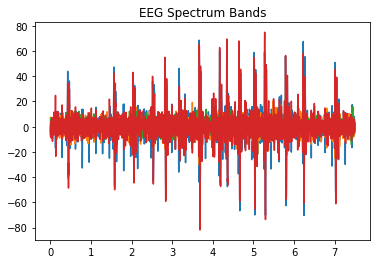

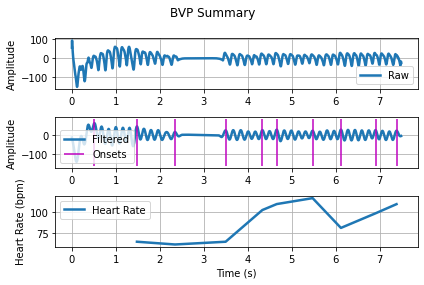

Picking Data Point 1602
(1920,)


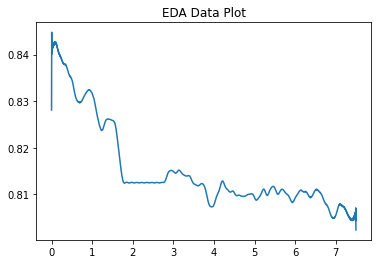

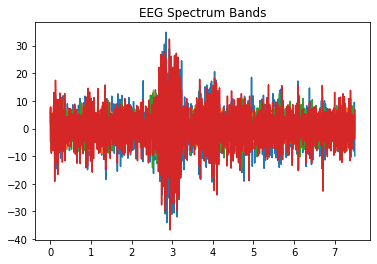

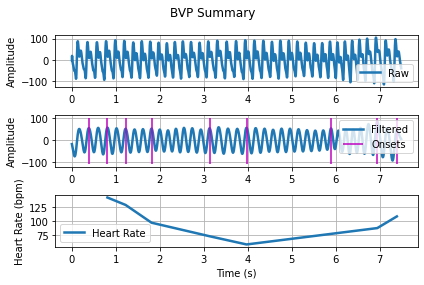

Picking Data Point 1506
(1920,)


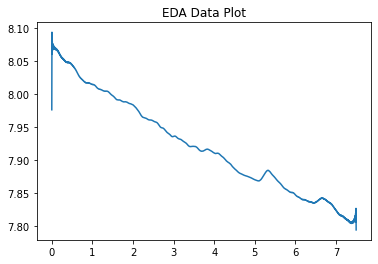

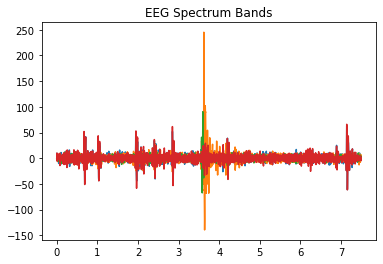

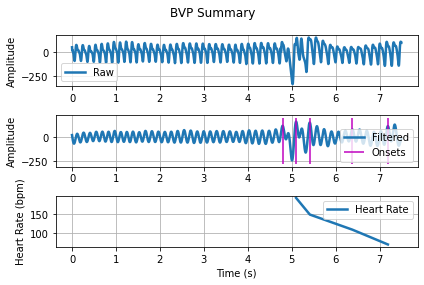

Picking Data Point 1433
(1920,)


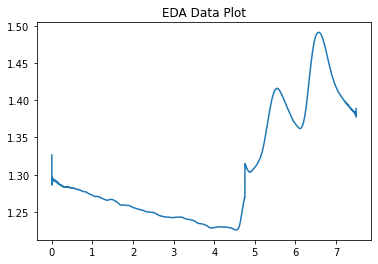

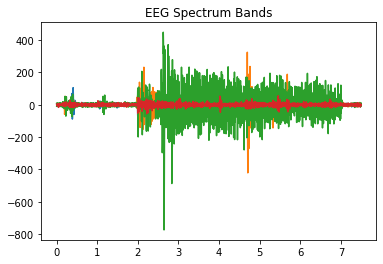

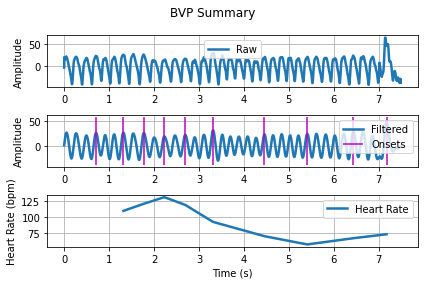

Picking Data Point 1418
(1920,)


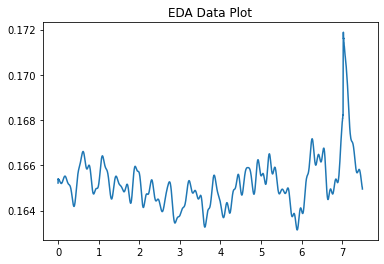

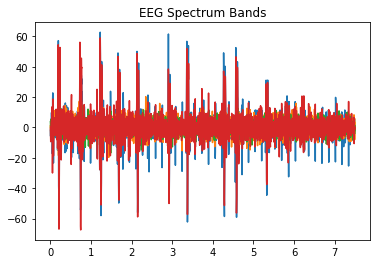

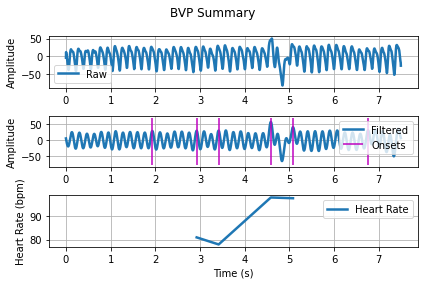

Picking Data Point 1356
(1920,)


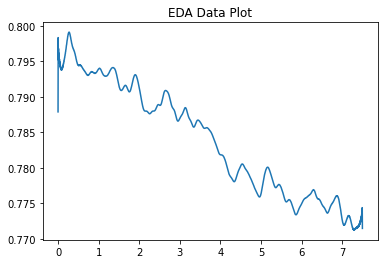

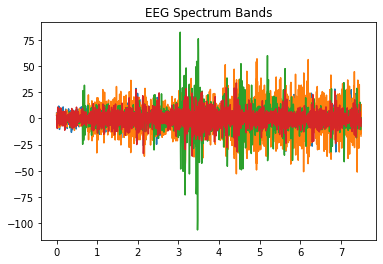

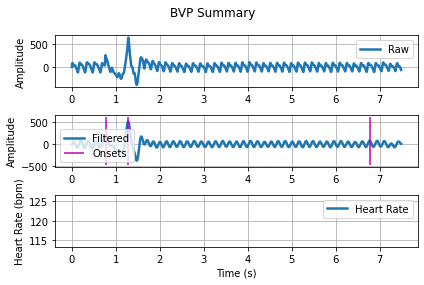

Picking Data Point 1285
(1920,)


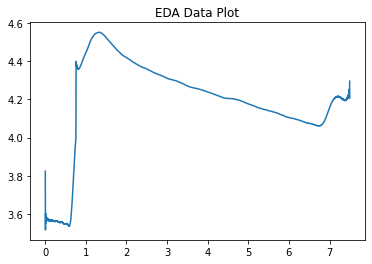

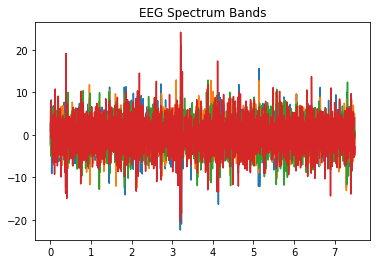

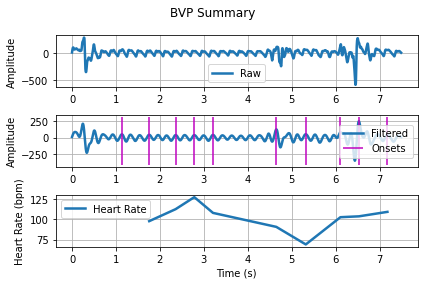

Picking Data Point 1238
(1920,)


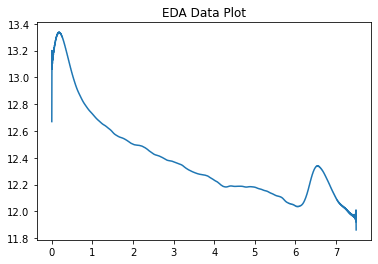

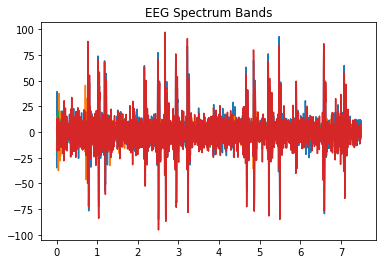

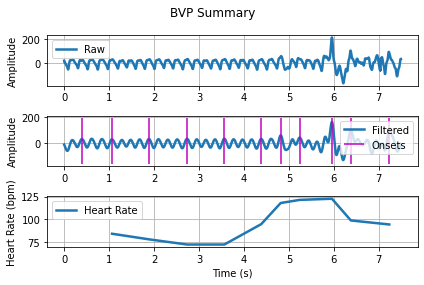

Picking Data Point 1207
(1920,)


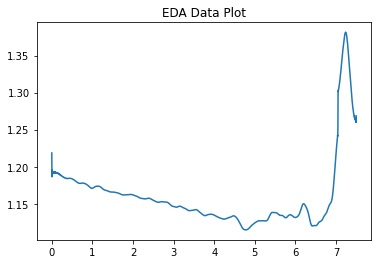

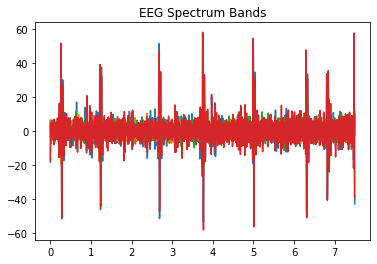

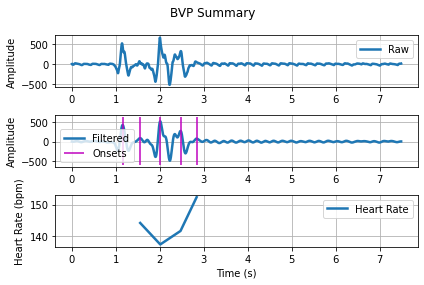

Picking Data Point 1063
(1920,)


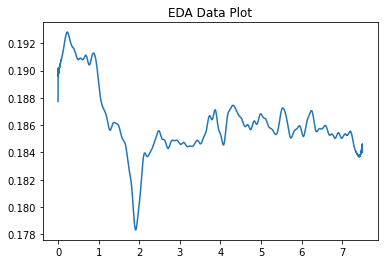

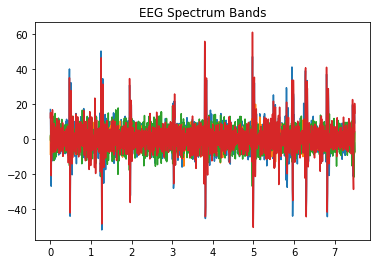

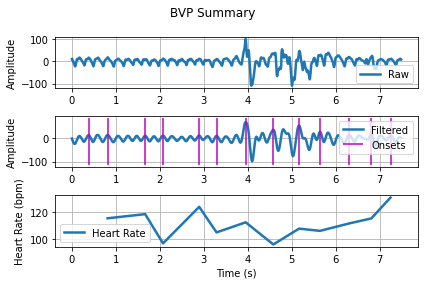

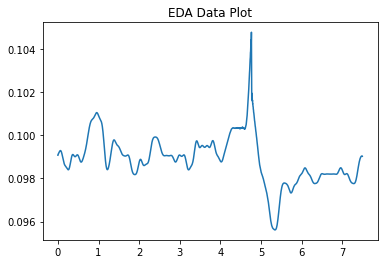

In [5]:
#Testing Data Integrity:
signals_of_interest = ['FILT_TP9', 'FILT_AF7', 'FILT_AF8', 'FILT_TP10','HR_EMPATICA','EDA_EMPATICA','BVP_Filt']

bad_data = [ 530,  788,  828,  965, 1063, 1207, 1238, 1285, 1356, 1418, 1433,
       1506, 1602, 1722]

for _ in range(10):
    i = bad_data.pop()
    # i = np.random.randint(0,len(X_train))
    print(f"Picking Data Point {i}")
    eeg_data = X_train[i,:,:-3]
    plt.figure()
    plt.plot([i/256 for i in range(len(eeg_data))],eeg_data)
    plt.title("EEG Spectrum Bands")
    bvp_data = X_train[i,:,np.array(signals_of_interest) == 'BVP_Filt'].flatten()
    print(bvp_data.shape)
    _, _, _, _, heart_rate = bvp(bvp_data,256,show=True)
    eda_data = X_train[i,:,np.array(signals_of_interest) == 'EDA_EMPATICA'].flatten()
    plt.figure()
    plt.plot([i/256 for i in range(len(eda_data))],eda_data)
    plt.title("EDA Data Plot")

### Physiological CNN Architecture and Training

In [11]:
import tensorflow as tf
print("Tensorflow version: ",tf.__version__)
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, AveragePooling1D, MaxPooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D, DepthwiseConv1D, SeparableConv1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

Tensorflow version:  2.8.0


In [221]:
def PhysioCNN(nb_classes, Chans = 7, Samples = 256,
             dropoutRate = 0.5, kernLength = 64,
             D = 1, F2 = 16, norm_rate = 0.25,
             output_type = "Regression"):
    """
    PhysioCNN is a 1D CNN that takes in several channels of physiological data
    and makes predictions about the emotional state of users. The prediction
    may be a Regression estimate of the self-reported user ratings or a classification
    of a discrete emotion.

    nb_classes: int,number of classes that will be predicted
    Chans: int, the number of channels of physiological data
    Samples: int, the number of samples per physiological signal
    dropoutRate: foat, the dropout rate before the flattening layer
    kernelLength: int, the length of the 1D convolutions
    D: int, specifies the depth multiplier for first 1D convolution
    F2: int, number of filters in the second layer
    norm_rate: float, the normalization rate
    dropoutType: str, type of Dropout

    return: The Model built with tensorflow
    """
    dropoutType = Dropout

    X   = Input(shape = (Samples, Chans))
    conv1d       = DepthwiseConv1D(kernLength, use_bias = False,
                                   depth_multiplier = D,padding='same')(X)
    convSeparable       = SeparableConv1D(F2,kernLength,
                                   use_bias = False, padding = 'same')(conv1d)
    convSeparable       = BatchNormalization()(convSeparable)
    convSeparable       = Activation('elu')(convSeparable)
    convSeparable       = AveragePooling1D(4)(convSeparable)
    convSeparable       = SeparableConv1D(F2,int(kernLength/2),
                                   use_bias = False, padding = 'same')(convSeparable)
    convSeparable       = BatchNormalization()(convSeparable)
    convSeparable       = Activation('elu')(convSeparable)
    convSeparable       = AveragePooling1D(4)(convSeparable)
    convSeparable       = dropoutType(dropoutRate)(convSeparable)

    flatten      = Flatten(name = 'flatten')(convSeparable)

    dense        = Dense(nb_classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    if output_type == "Regression":
        output      = Activation('linear', name = 'linear')(dense)
    elif output_type == "Classification":
        output      = Activation('softmax', name = 'softmax')(dense)

    return Model(inputs=X, outputs=output)

In [222]:
PhysioCNN_model = PhysioCNN(9, Samples = 1920,kernLength = 512)
PhysioCNN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss= 'mean_squared_error')

In [223]:
PhysioCNN_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1920, 7)]         0         
                                                                 
 depthwise_conv1d_8 (Depthwi  (None, 1920, 7)          3584      
 seConv1D)                                                       
                                                                 
 separable_conv1d_16 (Separa  (None, 1920, 16)         3696      
 bleConv1D)                                                      
                                                                 
 batch_normalization_16 (Bat  (None, 1920, 16)         64        
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 1920, 16)          0         
                                                           

In [224]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, )
checkpoint_path = fr'{root}/Models/PhysioCNN_model_512_1920_TEST/'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only = True,
                                                 monitor='loss',
                                                 verbose=1)

number_of_iterations = 1000
batch_size = 32
history = PhysioCNN_model.fit(X_train, y_train, batch_size=32, epochs=number_of_iterations,validation_data=(X_test,y_test), callbacks=[cp_callback])

Epoch 1/1000
168/169 [============================>.] - ETA: 0s - loss: 1.2235
Epoch 1: loss improved from inf to 1.22244, saving model to C:\Users\nelso\Google Drive\School\MIT Spring2022\18.065\18065 Project/Models/PhysioCNN_model_512_1920_TEST\
INFO:tensorflow:Assets written to: C:\Users\nelso\Google Drive\School\MIT Spring2022\18.065\18065 Project/Models/PhysioCNN_model_512_1920_TEST\assets
169/169 [==============================] - 21s 113ms/step - loss: 1.2224 - val_loss: 1.2482
Epoch 2/1000
 48/169 [=======>......................] - ETA: 7s - loss: 1.0405

KeyboardInterrupt: 

In [264]:
PhysioCNN_model.save(fr'{root}/Models/PhysioCNN_model_512_1920_TEST/')

INFO:tensorflow:Assets written to: C:\Users\nelso\Google Drive\School\MIT Spring2022\18.065\18065 Project/Models/PhysioCNN_model_512_1920_2.0/assets


### Emotion Classification

In [225]:
PhysioCNN_class = PhysioCNN(10, Samples= 1920,kernLength= 512, output_type= "Classification")
PhysioCNN_class.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss= "categorical_crossentropy", metrics=['accuracy'])

In [226]:
checkpoint_path = fr'{root}/Models/PhysioCNN_classify_512_1920_TEST/'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only = True,
                                                 monitor='accuracy',
                                                 verbose=1)
y_train_hot = tf.one_hot(y_train_emotions-1,depth=10).numpy().squeeze()
y_test_hot = tf.one_hot(y_test_emotions-1,depth=10).numpy().squeeze()

number_of_iterations = 1000
batch_size = 32

history = PhysioCNN_class.fit(X_train, y_train_hot, batch_size=64, epochs=number_of_iterations,validation_data=(X_test,y_test_hot), callbacks=[cp_callback])

Epoch 1/1000
84/85 [============================>.] - ETA: 0s - loss: 2.5386 - accuracy: 0.1034
Epoch 1: accuracy improved from -inf to 0.10317, saving model to C:\Users\nelso\Google Drive\School\MIT Spring2022\18.065\18065 Project/Models/PhysioCNN_classify_512_1920_TEST\
INFO:tensorflow:Assets written to: C:\Users\nelso\Google Drive\School\MIT Spring2022\18.065\18065 Project/Models/PhysioCNN_classify_512_1920_TEST\assets
85/85 [==============================] - 15s 156ms/step - loss: 2.5381 - accuracy: 0.1032 - val_loss: 3.8133 - val_accuracy: 0.1052
Epoch 2/1000
18/85 [=====>........................] - ETA: 8s - loss: 2.3899 - accuracy: 0.1076

KeyboardInterrupt: 

### Analysis of Regression Results

In [179]:
cnn_regress_model = tf.keras.models.load_model(fr"{root}/Models/PhysioCNN_model_512_1920/")

In [24]:
y_predict = cnn_regress_model.predict(X_test)

In [25]:
labels_arr_order

{'AWE': 0,
 'DISGUST': 1,
 'SURPRISE': 2,
 'ANGER': 3,
 'ENTHUSIASM': 4,
 'LIKING': 5,
 'FEAR': 6,
 'AMUSEMENT': 7,
 'SADNESS': 8}

In [208]:
# Plots figure with the regression estimates vs. true emotion ratings vs. regression estimates with most variance

sns.set_theme(style="whitegrid")

target_emotions = ["Neutral","AMUSEMENT","ANGER","AWE","DISGUST","ENTHUSIASM","FEAR","LIKING","SADNESS","SURPRISE"]
labels_to_idx_order = {idx:e for e,idx in labels_arr_order.items()}
rated_emotions = [labels_to_idx_order[idx] for idx in range(9)]

avg_rating_true = np.zeros((len(target_emotions),y_test.shape[1]))
avg_rating_pred = np.zeros((len(target_emotions),y_test.shape[1]))
most_var_avg = np.zeros((len(target_emotions),y_test.shape[1]))
plt.rcParams['font.size'] = '8'

w,h = (15,8)
n_row,n_col = (2,5)
fig, ax = plt.subplots(n_row,n_col,sharex=True,sharey=True,figsize=(w,h))
plot_coord = [(x,y) for x in range(n_row) for y in range(n_col)]
not_plotted = plot_coord.copy()
for e in range(1,11):
    select_emotion = (y_test_emotions == e).flatten()
    emotion_y_test = y_test[select_emotion,:]
    emotion_y_pred = y_predict[select_emotion,:]

    # Getting average values for true labels vs. predicted labels
    avg_true = np.mean(emotion_y_test,axis=0)
    avg_rating_true[e-1,:] = avg_true
    true_se = st.sem(emotion_y_test,axis=0)

    avg_predict = np.mean(emotion_y_pred,axis=0)
    avg_rating_pred[e-1,:] = avg_predict
    pred_se = st.sem(emotion_y_pred,axis=0)

    # Getting average rated emotions for classifications with most variance
    predict_var = np.var(y_predict,axis=1)[select_emotion]
    ratio_select = sum(select_emotion)//4
    high_var_idx = np.argpartition(predict_var, -ratio_select)[-ratio_select:]
    most_var_preds = y_predict[select_emotion,:][high_var_idx,:]
    avg_predict_most_dev = np.mean(most_var_preds,axis=0)
    pred_most_dev_se = st.sem(avg_predict_most_dev,axis=0)
    most_var_avg[e-1,:] = avg_predict_most_dev

    x,y = plot_coord[e-1]
    ticks = [idx for idx in range(len(rated_emotions)) ]
    ax[x,y].errorbar(ticks,avg_predict,yerr=pred_se,fmt="d",color="r",label="Pred",capsize=5)

    ax[x,y].errorbar(ticks,avg_true,yerr=true_se,fmt="o",color="b",label="True",capsize=5)

    ax[x,y].errorbar(ticks,avg_predict_most_dev,yerr=pred_most_dev_se,fmt="^",color="c", label="HPred",capsize=5)
    ax[x,y].set_xticks(ticks,[e[:2] for e in rated_emotions],size = 14)
    ax[x,y].set_ylim(0,4)
    ax[x,y].set_title(f"{target_emotions[e-1]}")
    ax[x,y].figure.set_size_inches(w/n_col,h/n_row)
    not_plotted.remove((x,y))
    if (x,y) == (0,n_col-1):
        ax[x,y].legend(prop={"size":12})
for x,y in not_plotted:
    fig.delaxes(ax[x,y])
plt.tight_layout()

C:\Users\nelso\AppData\Local\Temp\ipykernel_36400\495744119.py:56: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


In [174]:
# Save a table that contains the differences between estimated emtions and reported emotions

pred_for_target = np.array([avg_rating_pred[idx,labels_arr_order[e]] if e != "Neutral" else 0
                                    for idx,e in enumerate(target_emotions)])
rating_for_target = np.array([avg_rating_true[idx,labels_arr_order[e]] if e != "Neutral" else 0
                                    for idx,e in enumerate(target_emotions)])
dif_target = pred_for_target - rating_for_target

reg_results = np.hstack([avg_rating_pred - avg_rating_true, # individual emotion differences
                         dif_target[:,np.newaxis], # difference between target and predicted emotion
                         np.mean(np.abs(avg_rating_pred - avg_rating_true),axis=1,keepdims=True)]) # MAE dif
reg_results = np.vstack([reg_results, np.mean(reg_results,axis=0,keepdims=True)]) # Average across all columns

reg_results_df = pd.DataFrame(reg_results,index= target_emotions + ["Average"],
                              columns = [e[:2] for e in rated_emotions] + ["Target Dif.","MAE"])
reg_results_df.to_csv(r"C:\Users\nelso\Google Drive\School\MIT Spring2022\18.065\18065 Project\Graphs and Figures\regression_table_differences_new.csv")

In [175]:
# Save a table that contains the differences between estimated emtions with most variance and reported emotions

var_pred_target = np.array([most_var_avg[idx,labels_arr_order[e]] if e != "Neutral" else 0
                                    for idx,e in enumerate(target_emotions)])
var_rating_for_target = np.array([avg_rating_true[idx,labels_arr_order[e]] if e != "Neutral" else 0
                                    for idx,e in enumerate(target_emotions)])
dif_var_target = var_pred_target - var_rating_for_target

reg_results_var = np.hstack([most_var_avg - avg_rating_true, # individual emotion differences
                             dif_var_target[:,np.newaxis], # difference between target and predicted emotion
                             np.mean(np.abs(most_var_avg - avg_rating_true),axis=1,keepdims=True)]) # MAE dif
reg_results_var = np.vstack([reg_results_var,np.mean(reg_results_var,axis=0,keepdims=True)]) # Average across all columns

reg_results_var_df = pd.DataFrame(reg_results_var,index=target_emotions + ["Average"],
                              columns = [e[:2] for e in rated_emotions] + ["Target Dif.","MAE"])
reg_results_var_df.to_csv(r"C:\Users\nelso\Google Drive\School\MIT Spring2022\18.065\18065 Project\Graphs and Figures\regression_table_differences_most_var.csv")

### Analysis of Classification Results

In [227]:
cnn_class_model = tf.keras.models.load_model(fr"{root}/Models/PhysioCNN_classify_512_1920_softmax/")

In [228]:
y_pred_class = cnn_class_model.predict(X_test)

y_test_class = y_test_emotions-1

y_pred_class = np.argmax(y_pred_class,axis=1)

In [229]:
print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.87      0.19      0.32       139
           1       0.70      0.46      0.55       134
           2       0.72      0.59      0.65       143
           3       0.53      0.73      0.61       131
           4       0.68      0.73      0.70       126
           5       0.40      0.80      0.53       146
           6       0.55      0.65      0.59       131
           7       0.73      0.46      0.56       132
           8       0.63      0.74      0.68       144
           9       0.86      0.67      0.75       124

    accuracy                           0.60      1350
   macro avg       0.67      0.60      0.59      1350
weighted avg       0.66      0.60      0.59      1350



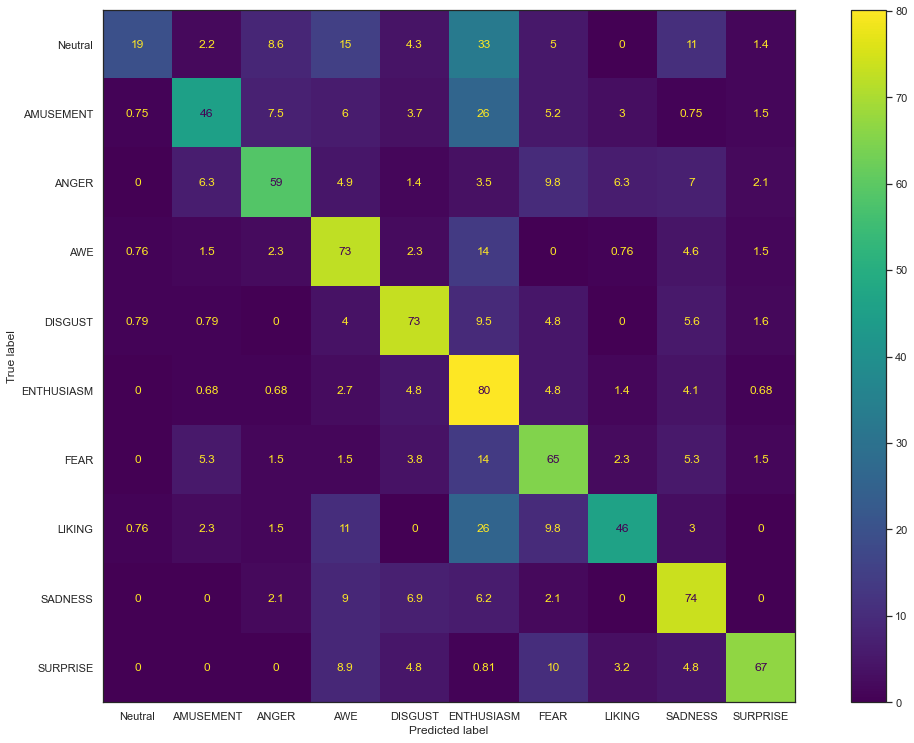

In [230]:
sns.set_theme(style="white")

cm = confusion_matrix(y_test_class,y_pred_class, normalize='true') * 100
disp_cm = ConfusionMatrixDisplay(cm, display_labels=target_emotions)

fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

plt.tight_layout()

cm_plot = disp_cm.plot(ax=ax)